In [ ]:
# !apt-get install graphviz libgraphviz-dev pkg-config

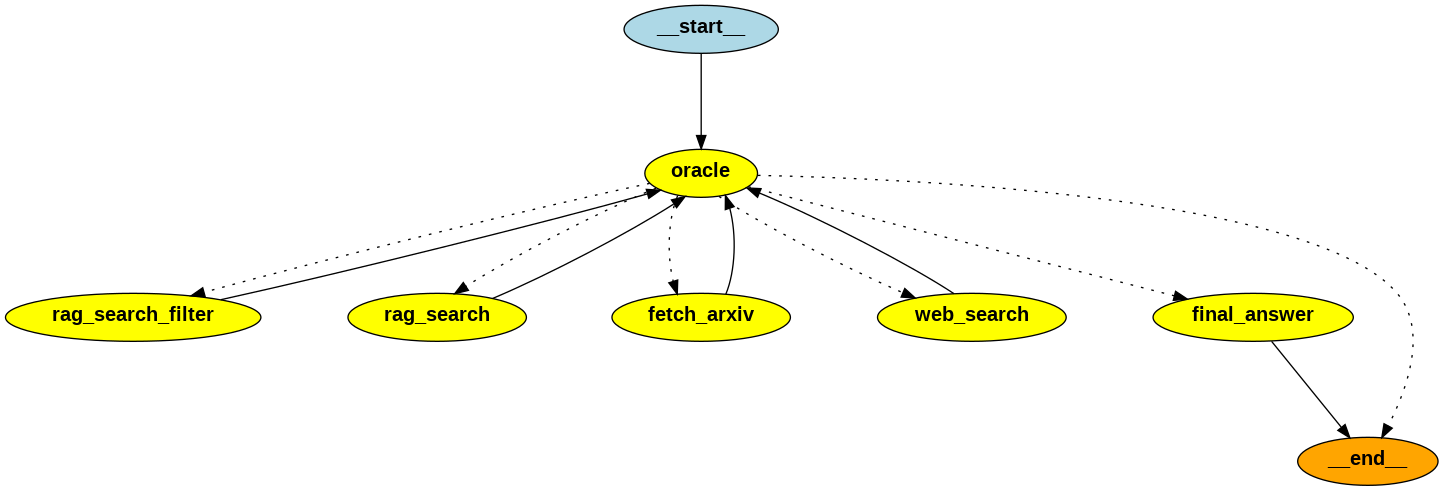

Now we install Python libraries:

In [2]:
# !pip install -qU datasets  langchain-pinecone langchain-openai langchain langchain-core langgraph  semantic-router google-search-results  pygraphviz

In [3]:
# !pip install cohere  duckduckgo-search  psycopg2-binary  

## Research Agent Overview

In [1]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [2]:
!which python

/home/manish/miniconda3/envs/lang/bin/python


In [3]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

Building a knowledge base:

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load the .env file


True

In [5]:
import os
from getpass import getpass

from langchain_google_genai import GoogleGenerativeAIEmbeddings

encoder = GoogleGenerativeAIEmbeddings(model = "models/text-embedding-004")

## Redis

In [6]:
import os

REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")
print(f"Connecting to Redis at: {REDIS_URL}")

Connecting to Redis at: redis://localhost:6379


In [7]:
import redis

redis_client = redis.from_url(REDIS_URL)
redis_client.ping()

True

In [8]:
# # To delete Redis Index
# from langchain_community.vectorstores.redis import Redis
# Redis.drop_index("arxiv_papers",True,redis_url= REDIS_URL)
# # List all keys
# keys = redis_client.keys('*')
# print(f"Found {len(keys)} keys. Deleting...")

# # Delete all keys
# if keys:
#     redis_client.delete(*keys) 

# redis_client.flushdb()

# # OR flush all databases (careful with this if using multiple DBs)
# redis_client.flushall()

In [9]:
from langchain_redis import RedisConfig, RedisVectorStore

# Define metadata schema to match your batch structure
config = RedisConfig(
    index_name="arxiv_papers",
    redis_url=REDIS_URL,
    metadata_schema=[
        {"name": "title", "type": "text"},
        {"name": "content", "type": "text"},
        {"name": "arxiv_id", "type": "tag"},
        {"name": "references", "type": "tag"},  # Store references as tags for easy filtering
    ],
)

# Initialize the Redis vector store
vector_store = RedisVectorStore(encoder, config=config)

01:48:41 redisvl.index.index INFO   Index already exists, not overwriting.


In [10]:
!rvl index info -i arxiv_papers --port 6379



Index Information:
╭──────────────┬────────────────┬──────────────────┬─────────────────┬────────────╮
│ Index Name   │ Storage Type   │ Prefixes         │ Index Options   │   Indexing │
├──────────────┼────────────────┼──────────────────┼─────────────────┼────────────┤
│ arxiv_papers │ HASH           │ ['arxiv_papers'] │ []              │          0 │
╰──────────────┴────────────────┴──────────────────┴─────────────────┴────────────╯
Index Fields:
╭────────────┬─────────────┬────────┬────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬─────────────────┬────────────────╮
│ Name       │ Attribute   │ Type   │ Field Option   │ Option Value   │ Field Option   │ Option Value   │ Field Option   │   Option Value │ Field Option    │ Option Value   │
├────────────┼─────────────┼────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼─────────────────┼────────────────┤
│ text       │ text 

In [11]:
!rvl stats -i arxiv_papers --port 6379


Statistics:
╭─────────────────────────────┬─────────────╮
│ Stat Key                    │ Value       │
├─────────────────────────────┼─────────────┤
│ num_docs                    │ 10112       │
│ num_terms                   │ 68323       │
│ max_doc_id                  │ 10112       │
│ num_records                 │ 1.30145e+06 │
│ percent_indexed             │ 1           │
│ hash_indexing_failures      │ 0           │
│ number_of_uses              │ 78          │
│ bytes_per_record_avg        │ 14.5417     │
│ doc_table_size_mb           │ 1.08972     │
│ inverted_sz_mb              │ 18.0486     │
│ key_table_size_mb           │ 0.385449    │
│ offset_bits_per_record_avg  │ 10.1597     │
│ offset_vectors_sz_mb        │ 4.25637     │
│ offsets_per_term_avg        │ 2.70034     │
│ records_per_doc_avg         │ 128.704     │
│ sortable_values_size_mb     │ 0           │
│ total_indexing_time         │ 4675.9      │
│ total_inverted_index_blocks │ 75926       │
│ vector_index_sz_mb 

In [344]:
# from tqdm.auto import tqdm
# import numpy as np

# # Batch processing and upserting into Redis
# batch_size = 128

# data = dataset.to_pandas()
# idss = []

# for i in tqdm(range(128, 10000, batch_size)):
#     i_end = min(len(data), i + batch_size)
#     batch = data[i:i_end].to_dict(orient="records")

#     # Prepare metadata for Redis
#     metadata = [{
#         "title": str(r["title"]),
#         "content": str(r["content"]),
#         "arxiv_id": str(r["arxiv_id"]) ,
#         "references": ', '.join(r["references"].tolist()) if isinstance(r["references"], np.ndarray) else r["references"]  # Assuming references are stored as a list
#     } for r in batch]

#     # Generate unique IDs and extract content
#     ids = [str(r["id"]) for r in batch]
#     content = [r["content"] for r in batch]

#     # Generate embeddings using your encoder
#     # embeds = encoder(content)
#        # Use the .embed_documents() method to generate embeddings
#     # embeds = encoder.embed_documents(content)

#     # Upsert data into Redis vector store
#     # vector_store.upsert(vectors=zip(ids, embeds, metadata))
#         # Use add_texts to add data to Redis
#     ides = vector_store.add_texts(content,metadata)
#     idss.extend(ides)
#     # break


  0%|          | 0/78 [00:00<?, ?it/s]

In [14]:
vector_store.search(query="mixture of experts",search_type='similarity',max_results = 5)

[Document(metadata={'title': 'Fast Inference of Mixture-of-Experts Language Models with Offloading', 'content': '3 Selected experts for Mixtral-8x7B-Instruct woe 0 (top) and 15 ae =n a oa ao a â me: a n: ee Layer 15 expert # Layer 0 expert # MAUR STARR O However about |= and 4 training data owerful language model based trained Trans former f architecture Figure 1: An example of expert loading pattern in Mixtral-8x7B-Instruct for select layers. Blue cells indicate that a certain expert was active when encoding a certain token; deeper blue indicates higher gating weight. Small gray squares show which experts are cached with an LRU cache for k=2. # 3.1 Expert Locality and LRU caching As we discussed earlier in Section 2.1, Mixture-of-Experts language models were often observed to assign individual experts to distinct sub-tasks. However, this does not mean that the model uses the same expert over long stretches of tokens. Instead, some experts are active in short sequences of 2-4 tokens, w

### ArXiv Paper Fetch

In [15]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [16]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [17]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [18]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


### Web Search

In [19]:
import requests
from bs4 import BeautifulSoup
from transformers import pipeline
from duckduckgo_search import DDGS


def duckduckgo_search(query, max_results=5):
    results = DDGS().text(query, max_results=max_results)
    for r in results:
        r['link'] = r.pop('href')
        r['snippet'] = r.pop('body')
    return results

def extract_page_content(url):
    """Fetch and extract text from a webpage."""
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract text from <p> tags to get meaningful content
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")]
        return " ".join(paragraphs)[:3000]  # Limit to 3000 chars for the QA model
    except Exception as e:
        print(f"Failed to fetch content from {url}: {e}")
        return ""

def get_direct_answer(question, max_results=5, indepth = False):
    """Fetch search results, extract web content, and get a direct answer."""
    search_results = duckduckgo_search(question, max_results)
    # print(search_results)
    
    if indepth:
        qa_pipeline = pipeline("summarization", model="knkarthick/MEETING_SUMMARY", device='cuda', use_fast=True )
        combined_context = []
        for idx, result in enumerate(search_results):
            content = extract_page_content(result["link"])
            combined_context.append(content)
        
        answer = qa_pipeline(combined_context,  batch_size=2)
        for idx, (ans, result) in enumerate(zip(answer, search_results.copy())):
            search_results[idx]['snippet'] = ans['summary_text']

    return search_results

/home/manish/.local/lib/python3.10/site-packages/bs4/css.py:8: UserWarning: The soupsieve package is not installed. CSS selectors cannot be used.
  warnings.warn(


In [20]:
query = "coffee"
search_results = get_direct_answer(query, max_results=5,indepth=False)

print("Search Results:")
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in search_results]
)
print(contexts)

Search Results:
Coffee and health: What does the research say? - Mayo Clinic
Coffee may have some health benefits, such as protecting against Parkinson's disease, type 2 diabetes and liver disease. But it also has potential risks, such as raising blood pressure and cholesterol levels. Learn more from Mayo Clinic experts.
https://www.mayoclinic.org/healthy-lifestyle/nutrition-and-healthy-eating/expert-answers/coffee-and-health/faq-20058339
---
9 Health Benefits of Coffee, Based on Science
Coffee is more than a stimulant that boosts your energy. It may also lower your risk of type 2 diabetes, depression, liver disease, and more. Learn about the evidence-based benefits of coffee and how much to drink for optimal health.
https://www.healthline.com/nutrition/top-evidence-based-health-benefits-of-coffee
---
Why Is Coffee Good for You? Here Are 7 Reasons - Healthline
Coffee can make you smarter, burn fat, lower diabetes and dementia risk, and more. Learn how coffee affects your brain, body, a

We put this process into a tool:

In [21]:
@tool("web_search")
def web_search(query: str):
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    results = get_direct_answer(query, max_results=1,indepth=False)
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

### RAG Tools

In [22]:
from langchain_core.tools import tool
from langchain_community.vectorstores.redis import RedisTag
from langchain_core.messages import ToolMessage

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x.metadata['title']}\n"
            f"Content: {x.metadata['content']}\n"
            f"ArXiv ID: {x.metadata['arxiv_id']}\n"
            f"Related Papers: {x.metadata['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str#ToolMessage(content=context_str)

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xc = vector_store.similarity_search(query=query,k=6,filter=str(RedisTag('arxiv_id') == arxiv_id))
    context_str = format_rag_contexts(xc)
    return context_str#ToolMessage(content=context_str)

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xc = vector_store.similarity_search(query=query,k=2)
    context_str = format_rag_contexts(xc)
    return context_str#ToolMessage(content=context_str)

### Final Answer

In [23]:
@tool("final_answer")
def final_answer(
    introduction: str = "",
    research_steps: str= "",
    main_body: str= "",
    conclusion: str= "",
    sources: str= ""
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

In [24]:
@tool("force_answer")
def force_answer(context: str):
    """Provides a response based on the available context."""
    return context


## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.
{tools}

Tool Usage Status:
{tool_usage}

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. 
Important: Each tool can only be used {max_uses} times total. Check the Tool Usage Status above before using any tool.
If a tool has reached its usage limit, you must find alternative ways to help or explain that you cannot complete the task.

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""


Test the agent quickly to confirm it is functional:

In [26]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_cohere import ChatCohere
from langchain_core.tools import BaseTool
from langchain_core.agents import AgentAction
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from typing import List, Optional, Dict, Any, Callable
from functools import wraps
from pydantic import Field
import os

class LimitedTool(BaseTool):
    """A wrapper for tools that enforces usage limits."""
    wrapped_tool: BaseTool = Field(description="The original tool being wrapped")
    max_uses: int = Field(default=3, description="Maximum number of times this tool can be used")
    usage_count: int = Field(default=0, description="Current number of times this tool has been used")
    
    def __init__(self, wrapped_tool: BaseTool, max_uses: int = 3):
        super().__init__(
            name=wrapped_tool.name,
            description=wrapped_tool.description,
            return_direct=wrapped_tool.return_direct,
            args_schema=wrapped_tool.args_schema,
            coroutine=wrapped_tool.coroutine,
            wrapped_tool=wrapped_tool,
            max_uses=max_uses,
            usage_count=0
        )
    
    def _run(self, *args: Any, config: Optional[Dict] = None, **kwargs: Any) -> Any:
        if self.usage_count >= self.max_uses:
            return f"Error: {self.name} has reached its usage limit of {self.max_uses} times."
        
        self.usage_count += 1
        return self.wrapped_tool._run(*args, config=config, **kwargs)

    async def _arun(self, *args: Any, config: Optional[Dict] = None, **kwargs: Any) -> Any:
        if self.usage_count >= self.max_uses:
            return f"Error: {self.name} has reached its usage limit of {self.max_uses} times."
        
        self.usage_count += 1
        if hasattr(self.wrapped_tool, '_arun'):
            return await self.wrapped_tool._arun(*args, config=config, **kwargs)
        return self.wrapped_tool._run(*args, config=config, **kwargs)


    def reset_usage(self):
        """Reset the usage count to 0."""
        self.usage_count = 0

class ToolManager:
    """Manages a collection of limited tools and their usage."""
    def __init__(self, tools: List[BaseTool], max_uses_per_tool: int = 3):
        self.original_tools = tools
        self.limited_tools = [LimitedTool(tool, max_uses_per_tool) for tool in tools]
        self.max_uses = max_uses_per_tool
        
    def get_tools(self) -> List[LimitedTool]:
        """Get the list of limited tools."""
        return self.limited_tools
    
    def get_usage_status(self) -> str:
        """Get a formatted string showing current tool usage."""
        status = []
        for tool in self.limited_tools:
            remaining = tool.max_uses - tool.usage_count
            status.append(f"{tool.name}: {remaining}/{tool.max_uses} uses remaining")
        return "\n".join(status)
    
    def reset_all(self):
        """Reset usage counts for all tools."""
        for tool in self.limited_tools:
            tool.reset_usage()

def format_tool_descriptions(tools: List[LimitedTool]) -> str:
    return "\n".join([f"- {tool.name}: {tool.description}" for tool in tools])

def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

# Initialize tool manager with your tools
tool_manager = ToolManager(
    tools=[
        rag_search_filter,
        rag_search,
        fetch_arxiv,
        web_search,
        # force_answer,
        final_answer
    ],
    max_uses_per_tool=5
)

# Use the limited tools from the tool manager
limited_tools = tool_manager.get_tools()
print(limited_tools)

from langchain_core.rate_limiters import InMemoryRateLimiter
rate_limiter = InMemoryRateLimiter(
    requests_per_second = 1/7,
    check_every_n_seconds = 0.1,
    max_bucket_size = 10
)
# Initialize Cohere LLM
llm = ChatCohere(
    temperature=0,
    cohere_api_key=os.getenv("COHERE_API_KEY"),
    model='command-r-plus-08-2024',
    rate_limiter = rate_limiter
)

# Create the prompt template with tool usage information
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("ai", "I am providing scratchpad till now: {scratchpad}"),

    ("user", "{input} try to answer using scratchpad and tools provided. Use tools if necessary.your tool usage limit {tool_usage}. IF LOW ON ONE TOOL USE OTHER TOOLS. FOLLOW SYSTEM PROMPT strictly."),
])
# Use the limited tools in the oracle
oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"],
        ),
        "tools": lambda _: format_tool_descriptions(limited_tools),
        "tool_usage": lambda _: tool_manager.get_usage_status(),
        "max_uses": lambda _: tool_manager.max_uses
    }
    | prompt
    | llm.bind_tools(limited_tools)
)


[LimitedTool(name='rag_search_filter', description='Finds information from our ArXiv database using a natural language query\n    and a specific ArXiv ID. Allows us to learn more details about a specific paper.', args_schema=<class 'langchain_core.utils.pydantic.rag_search_filter'>, wrapped_tool=StructuredTool(name='rag_search_filter', description='Finds information from our ArXiv database using a natural language query\n    and a specific ArXiv ID. Allows us to learn more details about a specific paper.', args_schema=<class 'langchain_core.utils.pydantic.rag_search_filter'>, func=<function rag_search_filter at 0x7f7c7d77a290>), max_uses=5), LimitedTool(name='rag_search', description='Finds specialist information on AI using a natural language query.', args_schema=<class 'langchain_core.utils.pydantic.rag_search'>, wrapped_tool=StructuredTool(name='rag_search', description='Finds specialist information on AI using a natural language query.', args_schema=<class 'langchain_core.utils.pyd

/tmp/ipykernel_91192/1421313121.py:105: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


In [27]:
from langgraph.graph import StateGraph, END
from langchain_core.agents import AgentAction
from typing import TypedDict, Annotated, List, Union
from typing import TypedDict, List, Sequence, Dict, Any
import operator

# Define the state schema
class AgentState(TypedDict):
    """Type definition for agent state."""
    input: str
    chat_history: List[Any]
    # intermediate_steps: Sequence[AgentAction]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

def create_context(state: AgentState) -> str:
    """Constructs a context string from the agent's state for the force_answer tool."""
    user_input = state["input"]
    chat_history = state["chat_history"]
    intermediate_steps = state["intermediate_steps"]

    # Format the chat history into a readable format
    formatted_history = "\n".join([f"User: {msg['input']}, Agent: {msg['output']}" for msg in chat_history])

    # Format the intermediate steps
    formatted_steps = "\n".join([f"Step {i+1}: Tool used - {step.tool}, Input - {step.tool_input}, Output - {step.log}" for i, step in enumerate(intermediate_steps)])

    # Construct the final context string
    
    context = (
        f"User Input: {user_input}\n\n"
        f"Chat History:\n{formatted_history}\n\n"
        f"Intermediate Steps:\n{formatted_steps}\n\n"
        "Due to reaching the tool's usage limit, the following information is available for the final answer:"
    )

    return context

# limited_tools = tool_manager.get_tools()
tool_str_to_func = {tool.name: tool for tool in limited_tools}

def run_oracle(state: AgentState) -> Dict[str, Any]:
    """Run the oracle with proper tool usage tracking."""
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    
    print("\nCurrent Tool Usage Status:")
    print(tool_manager.get_usage_status())
    
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    
    # Check if tool has reached its limit
    limited_tool = tool_str_to_func[tool_name]
    if limited_tool.usage_count >= limited_tool.max_uses:
        print(f"Warning: {tool_name} has reached its usage limit!")
        # Gather available context information
        context = create_context(state)

        action_out = AgentAction(
            tool="final_answer",
            tool_input={"input": f"Tool {tool_name} has reached its limit. Must provide final answer."},
            log="TBD"
        )

    else:
        action_out = AgentAction(
            tool=tool_name,
            tool_input=tool_args,
            log="TBD"
        )
    
    return {
        "intermediate_steps": [action_out]
    }

def router(state: AgentState) -> str:
    """Route to appropriate tool or final answer."""
    if isinstance(state["intermediate_steps"], (list, tuple)) and len(state["intermediate_steps"]) > 0:
        tool_name = state["intermediate_steps"][-1].tool
        limited_tool = tool_str_to_func[tool_name]
        
        if limited_tool.usage_count >= limited_tool.max_uses:
            print(f"Router: {tool_name} has reached limit, forcing final answer")
            return "final_answer"
        return tool_name
    else:
        print("Router invalid format")
        return "final_answer"

def run_tool(state: AgentState) -> Dict[str, Any]:
    current_step = state["intermediate_steps"][-1]
    tool_name = current_step.tool
    tool_args = current_step.tool_input
    limited_tool = tool_str_to_func[tool_name]

    print(f"{tool_name}.invoke(input={tool_args})")

    config = {}  # Add any necessary configurations if needed.
    if limited_tool.usage_count >= limited_tool.max_uses:
        out = f"Error: {tool_name} has reached its usage limit of {limited_tool.max_uses} times."
    else:
        out = limited_tool.invoke(input=tool_args, config=config)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    print("\nUpdated Tool Usage Status:")
    print(tool_manager.get_usage_status())

    return {"intermediate_steps": [action_out]}


# Create the graph with explicit state types
graph = StateGraph(AgentState)

# Add nodes with explicit state keys that can be modified
graph.add_node("oracle", run_oracle, )
for tool_name in tool_str_to_func:
    graph.add_node(tool_name, run_tool, )

# Set entry point
graph.set_entry_point("oracle")

# Add conditional edges
graph.add_conditional_edges(
    "oracle",
    router,
    # validate_args=True
)

# Add edges from tools back to oracle
for tool_name in tool_str_to_func:
    if tool_name not in ("final_answer" , "force_answer"):
        graph.add_edge(tool_name, "oracle")

# Add final answer edge to END
graph.add_edge("final_answer", END)

# Compile the graph
runnable = graph.compile()

def run_agent(query: str, chat_history: List = None) -> Dict[str, Any]:
    """Run the agent with proper state initialization and tool tracking."""
    initial_state = {
        "input": query,
        "chat_history": chat_history or [],
        "intermediate_steps": []
    }
    
    print("Initial Tool Usage Status:")
    print(tool_manager.get_usage_status())
    
    result = runnable.invoke(initial_state)
    
    print("\nFinal Tool Usage Status:")
    print(tool_manager.get_usage_status())
    
    return result

def reset_agent():
    """Reset all tool usage counts."""
    tool_manager.reset_all()
    print("Tool usage has been reset:")
    print(tool_manager.get_usage_status())

In [28]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

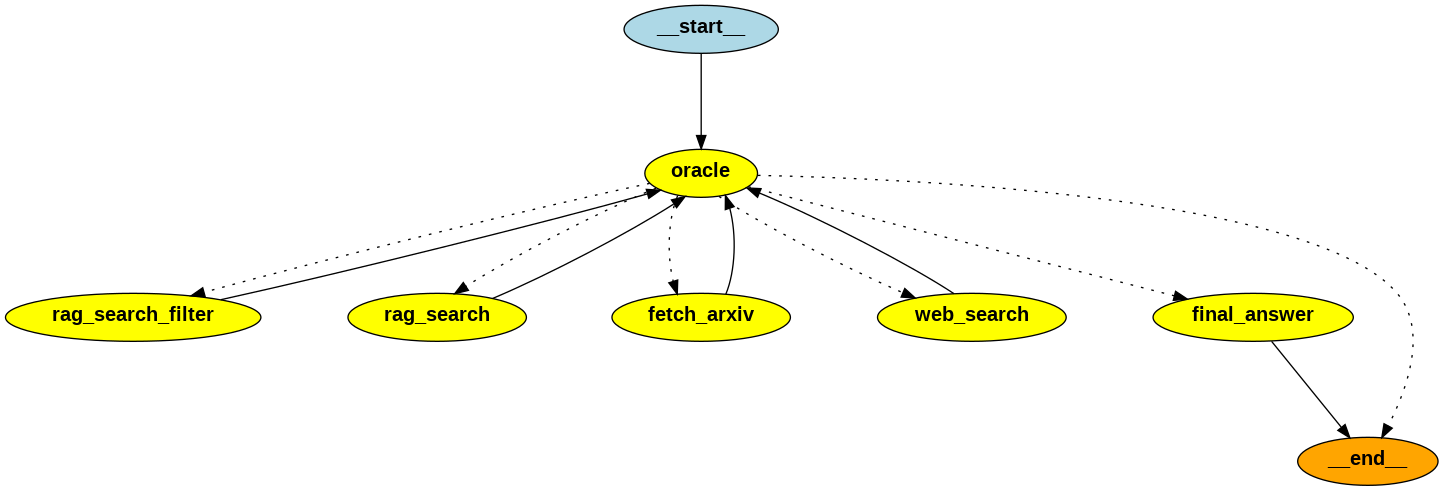

In [29]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [30]:
# Check tool usage
print(tool_manager.get_usage_status())

rag_search_filter: 5/5 uses remaining
rag_search: 5/5 uses remaining
fetch_arxiv: 5/5 uses remaining
web_search: 5/5 uses remaining
final_answer: 5/5 uses remaining


In [31]:
# Run the agent
result = run_agent("Write a report on LLM models")

# Check tool usage
print(tool_manager.get_usage_status())

# Reset if needed
reset_agent()

Initial Tool Usage Status:
rag_search_filter: 5/5 uses remaining
rag_search: 5/5 uses remaining
fetch_arxiv: 5/5 uses remaining
web_search: 5/5 uses remaining
final_answer: 5/5 uses remaining
run_oracle
intermediate_steps: []

Current Tool Usage Status:
rag_search_filter: 5/5 uses remaining
rag_search: 5/5 uses remaining
fetch_arxiv: 5/5 uses remaining
web_search: 5/5 uses remaining
final_answer: 5/5 uses remaining
web_search.invoke(input={'query': 'LLM models'})

Updated Tool Usage Status:
rag_search_filter: 5/5 uses remaining
rag_search: 5/5 uses remaining
fetch_arxiv: 5/5 uses remaining
web_search: 4/5 uses remaining
final_answer: 5/5 uses remaining
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'LLM models'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'LLM models'}, log='Large language model - Wikipedia\nA large language model (LLM) is a type of computational model designed for natural language processing tasks such as langu

In [32]:
print(build_report(
    output=result["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Large language models (LLMs) are a type of computational model designed for natural language processing tasks such as language generation. They acquire these abilities by learning statistical relationships from vast amounts of text during a self-supervised and semi-supervised training process. The largest and most capable LLMs are artificial neural networks built with a transformer architecture. These models typically encompass parameter counts reaching into the hundreds of billions, which are trained on extensive large-scale corpuses of textual data. The prominent instances entail OpenAI's GPT3&4, Anthropic's Claude, Google's PaLM, Bard, DeepMind's Chinchilla, and Gopher. However, none of them have been open-sourced so far, and some of them can only be exclusively accessible through APIs. Recently, the AI landscape has borne witness to the emergence of numerous open-source LLMs, characterized by publicly accessible model codes and weight parameters. Eleuther

Let's create a function to consume the agent output and format it into our report:

---